In [1]:
# Imports and set torch device
import numpy as np
import meshplot as mp
import torch
import sys
from scripts.helper_functions import segment
import kaolin as kal
import matplotlib.pyplot as plt
from meshseg.models.GLIP.glip import GLIPModel
import igl
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print('Torch will run on:', device)

# obj_path = 'data/demo/penguin.obj'
# obj_path = 'data/FAUST/scans/tr_scan_000.obj'
# obj_path = 'data/demo/B075QFCHM9.obj'
obj_path = 'data/demo/B07DBHPK4G.obj'

GM = GLIPModel()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nkhalil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nkhalil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
c:\ProgramData\miniforge3\envs\meshseg\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Torch will run on: cuda:0
VISION BACKBONE USE GRADIENT CHECKPOINTING:  False
LANGUAGE BACKBONE USE GRADIENT CHECKPOINTING:  False
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B


In [2]:
# Read mesh
mesh = kal.io.obj.import_mesh(
    obj_path,
    with_normals=True,
    with_materials=False,
)

vertices_tensor = mesh.vertices.to(device)
faces_tensor = mesh.faces.to(device)
# face_areas = kal.ops.mesh.face_areas(
#     vertices_tensor.unsqueeze(0),
#     faces_tensor
# ).view(len(mesh.faces))

vertices = vertices_tensor.detach().cpu().numpy()
faces = faces_tensor.detach().cpu().numpy()

print('Number of vertices: ', vertices.shape[0])
print('Number of faces: ', faces.shape[0])

Number of vertices:  13704
Number of faces:  22736


In [3]:
# Visualize mesh
mp.plot(vertices, faces)
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-9.685754…

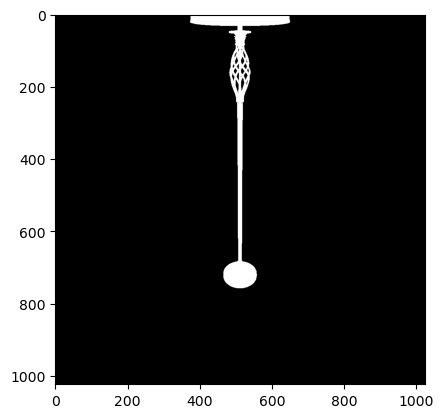

In [4]:
# Show a sample of rendered images
gen = torch.Generator()
std = 4
center_elev = 0
center_azim = 3.14
elev = torch.randn(1, generator=gen) * np.pi / std + center_elev
azim = torch.randn(1, generator=gen) * 2 * np.pi / std + center_azim
r = 2
x = r * torch.cos(elev) * torch.cos(azim)
y = r * torch.sin(elev)
z = r * torch.cos(elev) * torch.sin(azim)
pos = torch.tensor([x, y, z]).unsqueeze(0).to(device)
center = vertices_tensor.mean(dim = 0).to(device)
look_at = center-pos
# look_at = -pos
direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0).to(device)
camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction).to(device)
(
    face_vertices_camera,
    face_vertices_image,
    face_normals,
) = kal.render.mesh.prepare_vertices(
    mesh.vertices.to(device),
    mesh.faces.to(device),
    kal.render.camera.generate_perspective_projection(np.pi / 3).to(device),
    camera_transform=camera_proj,
)

image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
    1024,
    1024,
    face_vertices_camera[:, :, :, -1],
    face_vertices_image,
    kal.ops.mesh.index_vertices_by_faces(
            torch.ones(1, len(mesh.vertices), 3).to(device)
            * torch.tensor([0.5, 0.5, 0.5]).unsqueeze(0).unsqueeze(0).to(device),
            faces_tensor,
        ).to(device),
    face_normals[:, :, -1],
)
image = image_features.squeeze(0).detach().cpu().numpy()
image[image > 0.4] = 255
image = image.astype(np.uint8)
plt.imshow(image)
plt.show()

inference time per image: 0.8990159000000233
BoxList(num_boxes=1, image_width=1024, image_height=1024, mode=xyxy)


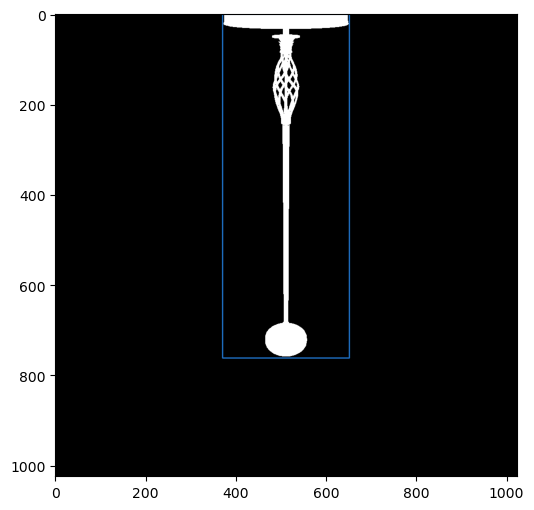

In [8]:
gmPrediction = GM.predict(image, 'body, lamp')
print(gmPrediction[1])
plt.figure(figsize=[8, 6])
plt.imshow(gmPrediction[0])
plt.show()

data/demo\B07DBHPK4G.obj
['the base of a lamp.', 'the body of a lamp.', 'the lampshade of a lamp.', 'the neck of a lamp.']
{'base': 0, 'body': 1, 'lampshade': 2, 'neck': 3, 'unknown': 4}
Reading the mesh...
Reading the mesh with path: data/demo\B07DBHPK4G.obj
	having 22736 faces and 13704 vertices
Creating the renderer...
Rendering the views...


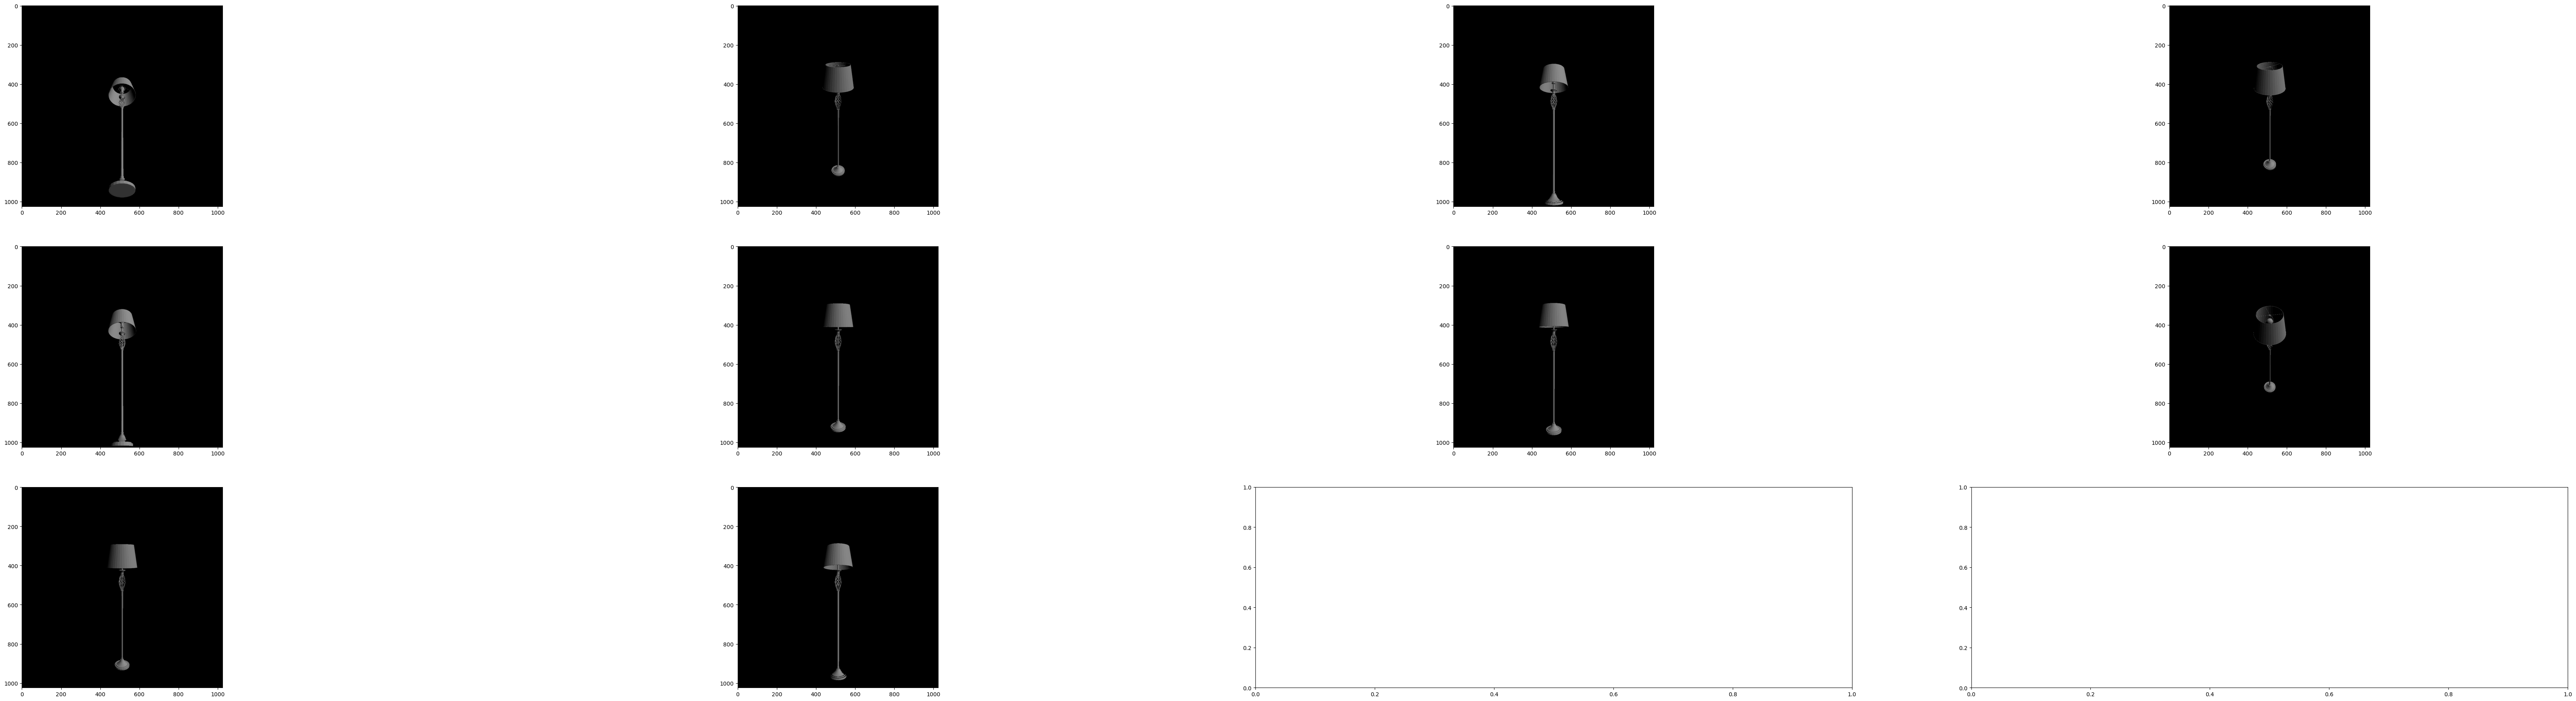

Rendering the views...done
VISION BACKBONE USE GRADIENT CHECKPOINTING:  False
LANGUAGE BACKBONE USE GRADIENT CHECKPOINTING:  False
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
Feeding the views to GLIP...
inference time per image: 0.9042468000000099
inference time per image: 0.504140100000086
inference time per image: 0.5003343000000768
inference time per image: 0.4958893000000444
inference time per image: 0.5139358999999786
inference time per image: 0.4970175000000836
inference time per image: 0.49742539999988367
inference time per image: 0.49475359999996726
inference time per image: 0.508369299999913
inference time per image: 0.5048827000000529
inference time per image: 0.5193311000000449
inference time per image: 0.4994060999999874
inference time per image: 0.49912509999990107
inference time per ima

0it [00:00, ?it/s]

In [13]:
segment(
    'configs/demo/B07DBHPK4G.yaml',
    'B07DBHPK4G.obj',
    'outputs/demo/ABO/B07DBHPK4G/'
    )

In [14]:
import json
output_file = open('./outputs/demo/ABO/B07DBHPK4G/face_preds.json')
output = np.array(json.load(output_file))
colors = np.unique(output, return_inverse=True)[1]
print('Prompts: ', np.unique(output))
mp.plot(vertices, faces, colors)
plt.show()

Prompts:  ['base' 'body' 'lampshade' 'neck' 'unknown']


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-9.685754…